# This is the notebook from the kaggle forestnet notebook

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import skimage.draw as sk
from fastai.vision.all import *
from fastai.imports import *

# Read data and create DataFrames
The dataset contains a lot of auxillary tabular data. In the ForestNet paper (https://stanfordmlgroup.github.io/projects/forestnet/) the tabular data imporved model performance when using Random Forest regression.  
However, the improvement was minimal when combined with UNet and ResNet architecture, which is why I have opted to drop it entriely in order to reduce time spent and complexity.   
I keep the merged_labels and the example_path from the csv-files.

In [2]:
train = pd.read_csv('../input/forestnet/ForestNetDataset/train.csv')
val = pd.read_csv('../input/forestnet/ForestNetDataset/val.csv')

In [3]:
train.drop(columns = ['label','latitude','longitude','year'], inplace = True)
val.drop(columns = ['label','latitude','longitude','year'], inplace = True)
train['is_valid'] = False
val['is_valid'] = True
imgset = pd.concat([train,val],ignore_index = True)
imgset.head()

,merged_label,example_path,is_valid
0,Plantation,examples/4.430849118860583_96.1016343478138,False
1,Other,examples/1.3323406178609702_109.37422873130464,False
2,Grassland shrubland,examples/-1.720266384577504_115.00699582064485,False
3,Smallholder agriculture,examples/-2.248346072674411_104.1357857482906,False
4,Plantation,examples/-2.100800102991412_113.0223763234016,False


create dictionary with our labels and their corresponding pixel value

In [4]:
codes_dict = {"Undefined": 0, "Plantation": 1, "Smallholder agriculture": 2,"Other": 3,"Grassland shrubland": 4}
codes_dict.values()

dict_values([0, 1, 2, 3, 4])

# Semantic segmentation data prep
each pixel inside the forest loss region is linked to a single class. This means that everything outside the forest loss region is undefined, and the result is a binary masks with labeled pixels inside the forest loss region and undefined pixels outside. In reality several deforestation drivers (labels) can be present in the same image, which is why my approach is to do per pixel segmentation on the entire image.  

The Forest loss regions are stored as pickle files and consists of MultiPolygons or single Polygons. As far as I know this datatype cannot be used in deep learning models so they have to be converted to PILMasks.
1. Iterate the Polygons and get their exterior coordinates  
2. Fill the outlines using the polygon2mask function https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon2mask
3. Map the mask(s) onto a zero initialized array with the correct resolution (in this case 332 x 332 pixels) using np.logical_or https://numpy.org/doc/stable/reference/generated/numpy.logical_or.html. This leaves us with a binary mask where ones are the forest loss region and zeroes are undefined.
4. Fill the values inside the forest loss region with the appropriate pixel value from our codes dictionary (1 for Plantation etc).  



In [5]:
def getEdges(polygon):
    edge = []
    for i in polygon.exterior.coords:
        x,y = i
        x = np.round(x).astype(int)
        y = np.round(y).astype(int)
        edge.append((x,y))
    return edge

In [6]:
def createPILMask(poly,label,codes):
    mask = np.zeros((332,332))
    edge = []
    if (poly.type == 'Polygon'):
        edge = getEdges(poly)
        pmask = sk.polygon2mask((332,332),edge)
        mask = np.logical_or(mask,pmask)
    else:
        for polygon in poly:
            edge = getEdges(polygon)
            pmask = sk.polygon2mask((332,332),edge)
            mask = np.logical_or(mask,pmask)
    mask = np.uint8(mask)
    mask = mask * labelToInt(label,codes)
    mask = np.rot90(mask,1)
    return PILMask.create(mask)

In [7]:
def labelToInt(label,codes):
    for j,i in enumerate(codes):
        if (i == label):
            return j

In [8]:
def getForestLoss(path):
    with open('../input/forestnet/ForestNetDataset/'+ path +'/forest_loss_region.pkl', 'rb') as f:
        return pickle.load(f)

# Find suitable weights for the labels
The labels are unevenly represented in the dataset.   
An intuitive approach would be to normalize the distribution and pass them as weights to the loss function in order to counter the imbalance of occurences in the dataset.  
This is the approach I went for although I suspect it is far from optimal. I would have liked to explore this step further as the weights greatly influence the performance of the model.

In [9]:
train_count = train.merged_label.value_counts()
train_count

merged_label
Plantation                 686
Smallholder agriculture    556
Other                      231
Grassland shrubland        143
Name: count, dtype: int64

In [10]:
val_count = val.merged_label.value_counts()
val_count

merged_label
Plantation                 218
Smallholder agriculture    140
Other                       70
Grassland shrubland         45
Name: count, dtype: int64

In [11]:
norm_train = np.linalg.norm(np.array(train_count.values))
norm_val = np.linalg.norm(np.array(val_count.values))

In [12]:
n_1 = ((train_count / norm_train).values)
n_2 = ((val_count / norm_val).values)
weights = (n_1 + n_2) / 2
# Assign a weight of zero to the "Undefined" label.
weights = np.insert(weights[::-1],0,0.0)
print(codes_dict.keys())
weights

dict_keys(['Undefined', 'Plantation', 'Smallholder agriculture', 'Other', 'Grassland shrubland'])


array([0.        , 0.16007583, 0.25363712, 0.558147  , 0.77182238])

# Put the data in a DataBlock
since I created a is_valid column in my dataframe I can use the built in ColSplitter() to parse the training and validation data.  
Like in the paper I resize all images to 160x160 and randomly crop during training and center crop during prediction on validation/test.  
Ideally I would have experimented more with data augmentations but I ran out of GPU Quota. The variations I tried such as Dihedral, flips and zoom yielded no significant performance improvement.

In [13]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes = codes_dict)),
        splitter = ColSplitter(),
        get_x = lambda x: "../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png",
        get_y = lambda x: createPILMask(getForestLoss(x[1]),x[0],codes_dict),
        item_tfms=Resize(160,method = 'crop'),
        batch_tfms=[Normalize.from_stats(*imagenet_stats)])

/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_x = lambda x: "../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png",
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_y = lambda x: createPILMask(getForestLoss(x[1]),x[0],codes_dict),
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/737158304.py:9: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use t

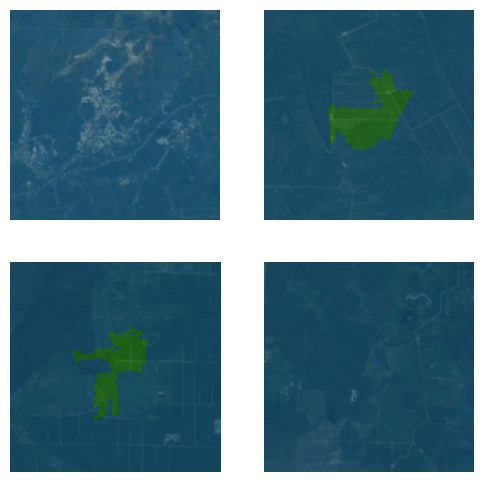

In [14]:
dls = db.dataloaders(imgset, bs = 4)
dls.show_batch(vmin = 0,vmax = 5)

# metrics
from https://github.com/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/04_Segmentation.ipynb  
I ignore the "Undefined" label when calculating pixel accuracy.

In [15]:
def accuracy(inp, targ):
    targ = targ.squeeze(1)
#   skip "Undefined"
    mask = targ != 0
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Learner and training
I initially used standard CrossEntropyLossFlat, but the LabelSmoothing-version yielded noticeable better results so I swapped. I suspect it is because the predicted probability values are pretty low for all labels.

In [ ]:
# learn = unet_learner(dls,
#                      resnet34,
#                      metrics = accuracy,
#                      loss_func = LabelSmoothingCrossEntropyFlat(axis = 1,
#                          weight = tensor(weights).cuda()))
# learn.loss_func

In [ ]:
import torch

# Check if MPS is available, otherwise use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Assuming 'weights' is your tensor of weights
# Convert weights to float32 and move to the correct device
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

learn = unet_learner(
    dls,
    resnet34,
    metrics=accuracy,
    loss_func=LabelSmoothingCrossEntropyFlat(axis=1, weight=weights_tensor)
)

learn.loss_func


In [18]:
import torch

# Check if MPS is available, otherwise use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Assuming 'weights' is your tensor of weights
# Convert weights to float32 and move to the correct device
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

learn = unet_learner(
    dls,
    resnet34,
    metrics=accuracy,
    loss_func=LabelSmoothingCrossEntropyFlat(axis=1, weight=weights_tensor)
)

learn.loss_func


/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_x = lambda x: "../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png",
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_y = lambda x: createPILMask(getForestLoss(x[1]),x[0],codes_dict),
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/737158304.py:9: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use t

FlattenedLoss of LabelSmoothingCrossEntropy()

In [19]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,accuracy,time
0,1.405854,1.354970,0.574496,07:23


/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_x = lambda x: "../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png",
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_y = lambda x: createPILMask(getForestLoss(x[1]),x[0],codes_dict),
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/737158304.py:9: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use t

epoch,train_loss,valid_loss,accuracy,time
0,1.240711,1.213720,0.598200,05:27
1,1.284003,1.270768,0.599832,04:35
2,1.216292,1.161129,0.611224,05:21
3,1.274367,1.156655,0.611205,05:34
4,1.005248,1.042983,0.684569,05:53
5,0.978993,1.066942,0.645010,06:30
6,0.765456,1.026342,0.700680,06:45
7,0.772627,1.024660,0.703072,07:09


# Validation accuracy
I do per pixel segmentation on the entire image. However, I am only interested in the forest loss region. I solve this by going through these steps    
1. UNet gives a probability map for each label (in this case output shape is 5x160x160 per prediction), so in order to compose a segmented image I take the maximum probability value for each pixel with argmax (now i have a 160x160 mask).
2. look at the pixel values inside the forest loss region .
3. The pixel with the most occurences is the predicted label (so if 60% of the pixels are 2, the predicted label is "Smallholder agriculture" etc).

In [20]:
preds = learn.get_preds()
preds[0].shape

/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_x = lambda x: "../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png",
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/3255013975.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_y = lambda x: createPILMask(getForestLoss(x[1]),x[0],codes_dict),
/var/folders/m3/l7r02k8n1qb59vz94prfz8pr0000gn/T/ipykernel_26690/737158304.py:9: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use t

torch.Size([473, 5, 160, 160])

In [21]:
def label_predict(target,pred,codes,test):
    maskindices = np.nonzero(target)
    if test:
        maskindices = zip(maskindices[0],maskindices[1])
    pred_labels = pred.argmax(dim = 0)
    label_vals = [pred_labels[i[0]][i[1]].item() for i in maskindices]
    return list(codes)[scipy.stats.mode(label_vals)[0][0]]

In [24]:
def accuracy(preds,df,codes):
    acc = {}
#   Ideally I dont want any predictions for the undefined label, unfortunately there are a few for most labels
    undefined_count = 0
    for label in df.merged_label.value_counts().index:
        label_indices = df[df.merged_label == label].index
        acc[label] = [label_predict(preds[1][ind],preds[0][ind],codes_dict,False) for ind in label_indices]
    for key in acc.keys():
        vals = acc[key]
#         undefined_count += len([x for x in vals if "Undefined" in x])
        acc[key] = len([x for x in vals if key in x]) / len(vals)
#     print('undefined', undefined_count)
    return acc

In [25]:
vset = imgset[imgset.is_valid == True]
vset.reset_index(drop = True, inplace = True)
accuracy(preds,vset,codes_dict)

IndexError: invalid index to scalar variable.

In [45]:
# Assuming the first element of the tuple is the logits tensor
logits = preds[0]

# Now you can apply argmax
predicted_classes = logits.argmax(dim=1)
predicted_classes

TensorBase([[[2, 2, 4,  ..., 4, 4, 4],
             [2, 2, 4,  ..., 4, 4, 4],
             [0, 0, 3,  ..., 4, 4, 0],
             ...,
             [0, 0, 4,  ..., 3, 0, 0],
             [0, 4, 4,  ..., 3, 3, 3],
             [1, 0, 4,  ..., 2, 2, 2]],

            [[2, 2, 0,  ..., 3, 0, 1],
             [2, 2, 4,  ..., 4, 3, 1],
             [0, 1, 0,  ..., 4, 0, 0],
             ...,
             [0, 0, 4,  ..., 0, 0, 1],
             [0, 3, 4,  ..., 3, 3, 1],
             [2, 0, 2,  ..., 2, 2, 2]],

            [[2, 2, 3,  ..., 1, 1, 1],
             [2, 2, 3,  ..., 1, 1, 1],
             [4, 3, 3,  ..., 4, 3, 0],
             ...,
             [1, 1, 2,  ..., 1, 1, 2],
             [1, 1, 3,  ..., 1, 3, 3],
             [2, 0, 2,  ..., 1, 2, 2]],

            ...,

            [[1, 0, 0,  ..., 4, 4, 0],
             [1, 4, 0,  ..., 4, 4, 4],
             [0, 0, 0,  ..., 4, 4, 0],
             ...,
             [0, 1, 2,  ..., 3, 3, 3],
             [1, 1, 2,  ..., 3, 3, 3],
       

In [44]:
import scipy.stats

def label_predict(target, pred, codes, test):
    # Get indices of non-zero elements in the target mask
    maskindices = np.nonzero(target)
    
    if test:
        maskindices = list(zip(maskindices[0], maskindices[1]))
    
    pred_labels = pred.argmax(dim=0)
    
    # If maskindices is empty, return the "Undefined" label
    if len(maskindices[0]) == 0:
        return "Undefined"
    
    # Extract label values based on the maskindices
    label_vals = [pred_labels[i[0]][i[1]].item() for i in maskindices]
    
    if not label_vals:
        return "Undefined"
    
    # Calculate the mode of the predicted labels
    mode_label = scipy.stats.mode(label_vals)[0][0]  # Get the most frequent label
    
    return list(codes)[mode_label]

def accuracy(preds, df, codes):
    acc = {}
    for label in df.merged_label.value_counts().index:
        label_indices = df[df.merged_label == label].index
        acc[label] = [label_predict(preds[1][ind], preds[0][ind], codes, False) for ind in label_indices]
    
    for key in acc.keys():
        vals = acc[key]
        acc[key] = len([x for x in vals if key in x]) / len(vals)
    
    return acc

vset = imgset[imgset.is_valid == True]
vset.reset_index(drop = True, inplace = True)
accuracy(preds,vset,codes_dict)

IndexError: invalid index to scalar variable.

In [ ]:
def predict_mask(target,pred,test):
    maskindices = np.nonzero(target)
    if test:
        maskindices = zip(maskindices[0],maskindices[1])
    pred_labels = pred.argmax(dim = 0)
    p_mask = np.zeros(target.shape)
    for i in maskindices:
        p_mask[i[0]][i[1]] = pred_labels[i[0]][i[1]].item()
    f, ax = plt.subplots(1,2,figsize=(20, 10))
    ax[0].imshow(target)
    ax[1].imshow(p_mask)
    ax[0].set_title("ground truth")
    ax[1].set_title("prediction")
    plt.show()

# Visualize predictions
I would have liked to include mapping of colors to labels here.

In [ ]:
predict_mask(preds[1][2],preds[0][2],False)
p = label_predict(preds[1][2],preds[0][2],codes_dict,False)
g = vset.iloc[1][0]
print("predicted label: ", p)
print("correct label: ", g)

In [ ]:
for i, j in enumerate(vset.head(10).values):
    f, ax = plt.subplots(1,2,figsize=(20, 10))
    im = PILImage.create("../input/forestnet/ForestNetDataset/"f'{j[1]}'"/images/visible/composite.png")
    ax[0].imshow(im)
    ax[1].imshow(preds[0][i].argmax(dim = 0))
    plt.show() 

# Examine model performance on test data
I use the composite images as input for the model on test data to ensure good quality of the input image. In the ForestNet paper the image captured temporally closest to the year of the forest loss event was primarily used as input.  

In [ ]:
test = pd.read_csv('../input/forestnet/ForestNetDataset/test.csv')
test.drop(columns = ['label','latitude','longitude','year'], inplace = True)

In [ ]:
def t_acc(df,codes):
#     undefined_count = 0
    acc = []
    label = df.iloc[0][0]
    for x in df.values:
        im = PILImage.create("../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png")
        AOI = createPILMask(getForestLoss(x[1]),x[0],codes)
        p = learn.predict(im)
        acc.append(label_predict(AOI.crop_pad(p[2].shape[1]),p[2],codes,True))
#     print(len([x for x in acc if "Undefined" in x]))
    return (len([x for x in acc if label in x]) / len(acc))

In [ ]:
t_plant = test[test.merged_label == 'Plantation']
t_other = test[test.merged_label == 'Other']
t_grass = test[test.merged_label == 'Grassland shrubland']
t_small = test[test.merged_label == 'Smallholder agriculture']

plantation = t_acc(t_plant,codes_dict)
other = t_acc(t_other,codes_dict)
grass = t_acc(t_grass,codes_dict)
small = t_acc(t_small,codes_dict)

In [ ]:
print('plantation accuracy: ', np.around(plantation,4))
print('other accuracy: ', np.around(other,4))
print('grassland shrubland accuracy: ', np.around(grass,4))
print('smallholder agriculture accuracy: ', np.around(small,4))